### ResNet and ResNext for TensorFlow based on Pytorch Code

In [41]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, Add, ZeroPadding2D
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, MaxPool2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
from typing import Type, Any, Union, List
import numpy as np
import os
import math
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
weight_decay = 0.0005

### ResNet and ResNext for ImageNet

In [54]:
def BasicBlock(x, inplanes: int, planes: int, strides: int = 1, groups: int = 1, base_width: int = 64, name=None):
    expansion = 1

    if strides != 1 or inplanes != planes * expansion:
        shortcut = Conv2D(planes * expansion, 1, strides=strides, 
                          kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay), 
                          name=name + '_0_conv')(x)
        shortcut = BatchNormalization(name=name + '_0_bn')(shortcut)
    else:
        shortcut = x
    
    x = Conv2D(planes, 3, strides=strides, padding='same', 
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay), 
               name=name + '_1_conv')(x)
    x = BatchNormalization(name=name + '_1_bn')(x)
    x = Activation('relu', name=name + '_1_relu')(x)

    x = Conv2D(planes, 3, padding='same', 
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay), 
               name=name + '_2_conv')(x)
    x = BatchNormalization(name=name + '_2_bn')(x)

    x = Add(name=name + '_add')([shortcut, x])
    x = Activation('relu', name=name + '_out')(x)
    return x


def Bottleneck(x, inplanes: int, planes: int, strides: int = 1, groups: int = 1, base_width: int = 64, name=None):
    expansion = 4
    width = int(planes * (base_width / 64.)) * groups

    if strides != 1 or inplanes != planes * expansion:
        shortcut = Conv2D(planes * expansion, 1, strides=strides, 
                          kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay), 
                          name=name + '_0_conv')(x)
        shortcut = BatchNormalization(name=name + '_0_bn')(shortcut)
    else:
        shortcut = x
    
    x = Conv2D(width, 1, strides=strides, 
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay), 
               name=name + '_1_conv')(x)
    x = BatchNormalization(name=name + '_1_bn')(x)
    x = Activation('relu', name=name + '_1_relu')(x)

    x = Conv2D(width, 3, padding='same', groups=groups, 
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay),
               name=name + '_2_conv')(x)
    x = BatchNormalization(name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_relu')(x)

    x = Conv2D(planes * expansion, 1, 
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay), 
               name=name + '_3_conv')(x)
    x = BatchNormalization(name=name + '_3_bn')(x)

    x = Add(name=name + '_add')([shortcut, x])
    x = Activation('relu', name=name + '_out')(x)
    return x


def ResNet(input_shape, 
           expansion, 
           block: Type[Union[BasicBlock, Bottleneck]], 
           layers: List[int], 
           num_classes: int = 1000, 
           groups: int = 1, 
           width_per_group: int = 64) -> Model:
    global inplanes
    inplanes = 64
    expansion = expansion
    inputs = Input(shape=input_shape)
    x = ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(inputs)
    x = Conv2D(inplanes, kernel_size=7, strides=2, 
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay), 
               name='conv1_conv')(x)
    x = BatchNormalization(name='conv1_bn')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = MaxPool2D(3, strides=2, name='pool1_pool')(x)

    def _make_layer(x, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    strides: int = 1, name=None):
        global inplanes
        x = block(x, inplanes, planes, strides, groups, width_per_group, name=name + '_block1')
        inplanes = planes * expansion
        for i in range(2, blocks + 1):
            x = block(x, inplanes, planes, 1, groups, width_per_group, name=name + '_block' + str(i))
        return x


    x = _make_layer(x, block, 64, layers[0], name='conv2')
    x = _make_layer(x, block, 128, layers[1], strides=2, name='conv3')
    x = _make_layer(x, block, 256, layers[2], strides=2, name='conv4')
    x = _make_layer(x, block, 512, layers[3], strides=2, name='conv5')

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def _resnet(input_shape, 
            expansion, 
            block: Type[Union[BasicBlock, Bottleneck]],
            layers: List[int],
            **kwargs: Any) -> ResNet:
    model = ResNet(input_shape, expansion, block, layers, **kwargs)
    return model


def resnet34(input_shape, **kwargs: Any):
    return _resnet(input_shape, 1, BasicBlock, [3, 4, 6, 3], **kwargs)


def resnet50(input_shape, **kwargs: Any):
    return _resnet(input_shape, 4, Bottleneck, [3, 4, 6, 3], **kwargs)


def resnext50_32x4d(input_shape, **kwargs: Any):
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet(input_shape, 4, Bottleneck, [3, 4, 6, 3], **kwargs)

### Model Summary

In [55]:
model = resnet34((224, 224, 3))
model.summary()
forward_pass = tf.function(model.call, input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])
graph_info = profile(forward_pass.get_concrete_function().graph, 
                     options=ProfileOptionBuilder.float_operation())

# The //2 is necessary since `profile` counts multiply and accumulate
# as two flops, here we report the total number of multiply accumulate ops
flops = graph_info.total_float_ops // 2
print('Flops: {:,}'.format(flops))

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_19[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

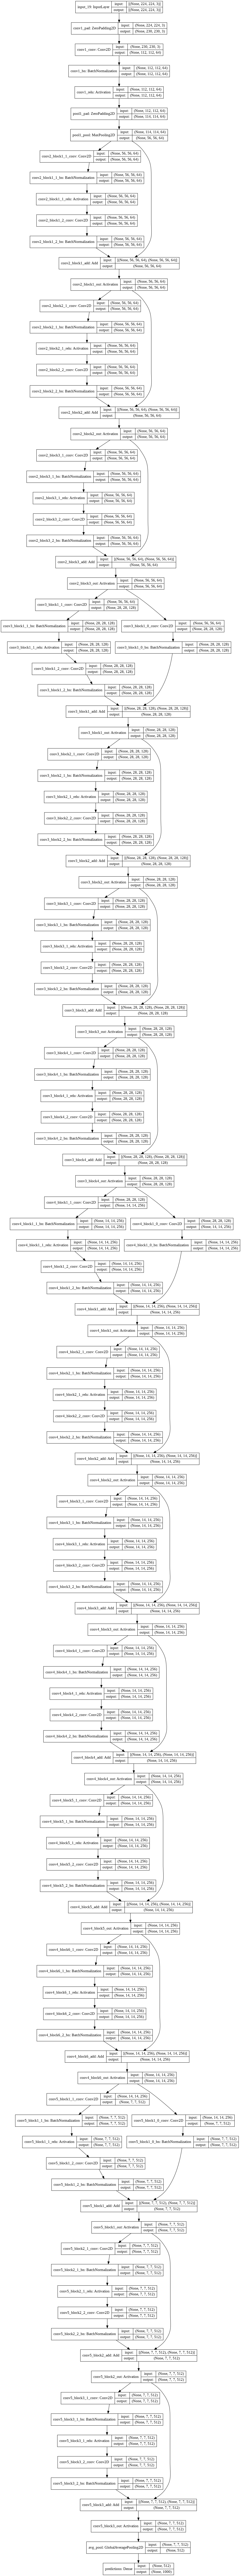

In [56]:
plot_model(model, show_shapes=True)

In [48]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops


print("The FLOPs is: {:,}".format(get_flops(model)), flush=True)

The FLOPs is: 7,551,375,216


In [ ]:
model = resnet50((224, 224, 3))
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

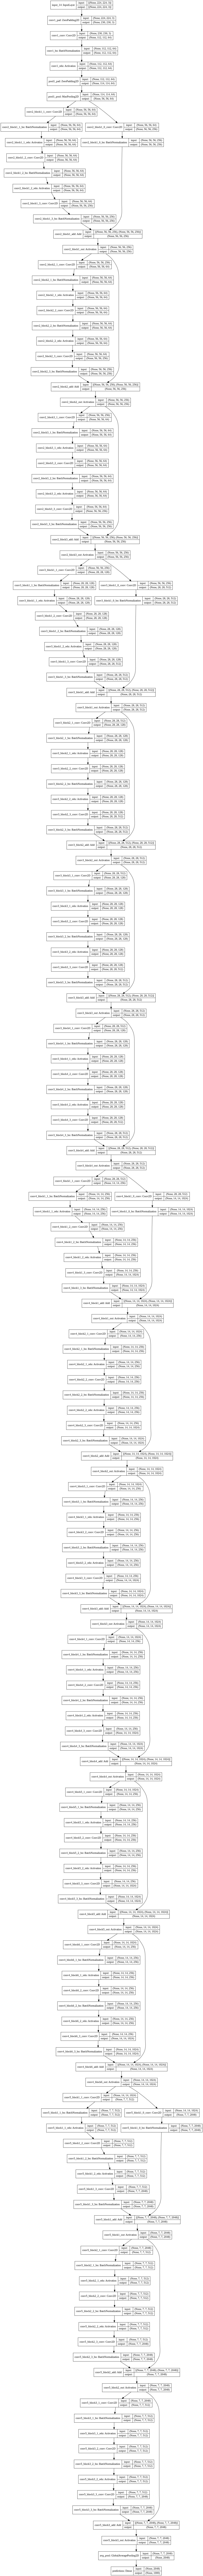

In [40]:
plot_model(model, show_shapes=True)